# Solving the poisson-drift-diffusion equation with Solcore

In this notebook we will go over how to handle the charge transport simulation part in the imodulator workflow by using `Solcore`. Our goal is to explore how to get the data from the `PhotonicDevice` to the charge transport simulator and how to inspect the data properly.

<div style="text-align: center;">
  <img src="support/main.png" alt="Alt text" style="max-width: 80%; height: auto;">
</div>

To illustrate how to do this, we will use the class developed in `Building a Photonic Device` tutorial: `InP_EOPM`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import imodulator
import shapely
import openbandparams as obp
from imodulator.ElectroOpticalModel import InGaAsPElectroOpticalModel
from imodulator.ChargeSimulator import ChargeSimulatorSolcore

%matplotlib inline

def tand_fitted_bcb(x):
    """
    Fitted to results from https://link.springer.com/article/10.1007/s10762-009-9552-0
    
    x must be in GHz
    """
    out =  0.0093839 - 0.01790336 * np.exp(-0.04773444 * (x - -4.64170761))

    if isinstance(x, (list, np.ndarray)):
        x = np.asarray(x)
    
        out[np.where(out<0.001)] = 0.001
    else:
        if out < 0.001:
            out = 0.001
    return out

class InP_EOPM:
    def __init__(
            self,
            **kwargs
    ):
        
        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m
        
        self.w_sig_metal = 5 # Width of signal metal in um
        self.metal_sep = 10 # Separation between signal and ground metals in um
        self.h_metal = 4 # Height of metals in um
        self.w_gnd_metal = 10
        
        self.w_wg = 1
        self.h_n = 0.4
        self.h_wg1 = 0.5
        self.h_wg2 = 0.3
        self.h_p1 = 1
        self.h_p2 = 0.2

        self.h_box = 4

        self.w_window = 100
        self.h_bottom = 30
        self.h_top = 30

        for kwarg, value in kwargs.items():
            if hasattr(self, kwarg):
                setattr(self, kwarg, value)
    
    def _make_meshes(self):
        # optical mesh
        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        # RF mesh
        self.rf_mesh_settings = {
            'substrate': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_right': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        # eo mesh
        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.5},
            'background': {'resolution': 0.5},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'n': {'resolution': 0.003},
            'wg1': {'resolution': 0.002},
            'wg2': {'resolution': 0.002},
            'p1': {'resolution': 0.003},
            'p2': {'resolution': 0.003},
        }

    def _create_polygons(self):
        #We will now set the RF properties of the metals and the BCB
        freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
            
        eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)
        eps_rf_metal = np.asarray([freq, eps_rf_metal])

        bcb_eps_real = 2.65*np.ones(100)
        bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

        bcb_eps = bcb_eps_real - 1j*bcb_eps_imag
        bcb_eps = np.asarray([freq, bcb_eps])
        
        #Now we create the PhotoPolygons
        self.substrate = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                -self.h_box
            ),
            rf_eps = 11.7,
            name = 'substrate',
            optical_material=3**2,
            eo_mesh_settings=self.eo_mesh_settings['substrate'],
            rf_mesh_settings=self.rf_mesh_settings['substrate'],
            optical_mesh_settings=self.optical_mesh_settings['substrate'],
        )

        self.background = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal + self.h_top
            ),
            rf_eps = 1,
            optical_material=1,
            eo_mesh_settings=self.eo_mesh_settings['background'],
            rf_mesh_settings=self.rf_mesh_settings['background'],
            optical_mesh_settings=self.optical_mesh_settings['background'],
            name = 'background'
        )

        self.box = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box,
                self.w_window/2,
                0
            ),
            rf_eps = 3.9 - 1j*3.9*0.001,
            optical_material=1.44**2,
            eo_mesh_settings=self.eo_mesh_settings['box'],
            rf_mesh_settings=self.rf_mesh_settings['box'],
            optical_mesh_settings=self.optical_mesh_settings['box'],
            name = 'box'
        )

        n_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.n = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                0,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n
            ),
            rf_eps = n_obp_material.dielectric(T=300),
            optical_material=n_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['n'],
            rf_mesh_settings=self.rf_mesh_settings['n'],
            optical_mesh_settings=self.optical_mesh_settings['n'],
            charge_mesh_settings=self.charge_mesh_settings['n'],
            name = 'n',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': n_obp_material,
                'sol_Nd': 1e18
            }
        )

        wg1_obp_material = obp.GaInPAs(T=300, As = 0.53, a = obp.InP.a())
        self.wg1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n,
                self.w_wg/2,
                self.h_n + self.h_wg1
            ),
            rf_eps = wg1_obp_material.dielectric(T=300),
            optical_material=wg1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg1'],
            rf_mesh_settings=self.rf_mesh_settings['wg1'],
            optical_mesh_settings=self.optical_mesh_settings['wg1'],
            charge_mesh_settings=self.charge_mesh_settings['wg1'],
            name = 'wg1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0.53,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg1_obp_material,
                'sol_Nd': 1e16
            }
        )

        wg2_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.wg2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2
            ),
            rf_eps = wg2_obp_material.dielectric(T=300),
            optical_material=wg2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg2'],
            rf_mesh_settings=self.rf_mesh_settings['wg2'],
            optical_mesh_settings=self.optical_mesh_settings['wg2'],
            charge_mesh_settings=self.charge_mesh_settings['wg2'],
            name = 'wg2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Nd': 1e16
            }
        )

        p1_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.p1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1
            ),
            rf_eps = p1_obp_material.dielectric(T=300),
            optical_material=p1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p1'],
            rf_mesh_settings=self.rf_mesh_settings['p1'],
            optical_mesh_settings=self.optical_mesh_settings['p1'],
            charge_mesh_settings=self.charge_mesh_settings['p1'],
            name = 'p1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Na': 1e17
            }
        )

        p2_obp_material = obp.GaInAs(T=300, a = obp.InP.a())
        self.p2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = p2_obp_material.dielectric(T=300),
            optical_material=p2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p2'],
            rf_mesh_settings=self.rf_mesh_settings['p2'],
            optical_mesh_settings=self.optical_mesh_settings['p2'],
            charge_mesh_settings=self.charge_mesh_settings['p2'],
            name = 'p2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': p2_obp_material,
                'sol_Na': 1e19
            }
        )

        self.bcb_far_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                0,
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_left'
        )

        self.bcb_far_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.metal_sep + self.w_gnd_metal + self.w_sig_metal/2,
                0,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_right'
        )

        self.bcb_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n,
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_left'
        )

        self.bcb_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.w_wg/2,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_right'
        )

        self.sig_metal = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2,
                self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings=self.rf_mesh_settings['sig_metal'],
            optical_mesh_settings=self.optical_mesh_settings['sig_metal'],
            name = 'sig_metal',
            calculate_current=True,
            d_buffer_current=min(self.w_sig_metal/20, self.h_metal/20, 0.05)
        )

        self.n_metal_left = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n,
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_left'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_left'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_left'],
            name = 'n_metal_left',
            calculate_current=False
        )

        self.n_metal_right = imodulator.MetalPolygon(
            shapely.box(
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_right'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_right'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_right'],
            name = 'n_metal_right',
            calculate_current=False
        )

    def _initialize_device(self):
        photo_polygons = [
            self.sig_metal,
            self.n_metal_left,
            self.n_metal_right,
            self.p2,
            self.p1,
            self.wg2,
            self.wg1,
            self.n,
            self.box,
            self.bcb_left,
            self.bcb_right,
            self.bcb_far_left,
            self.bcb_far_right,
            self.substrate,
            self.background
        ]
        
        #Just in case there are empty polygons
        idxs_to_remove = []
        for i, poly in enumerate(photo_polygons):
            if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
                idxs_to_remove.append(i)
        for i in idxs_to_remove[::-1]:
            del photo_polygons[i]
        self.device = imodulator.PhotonicDevice(
            photo_polygons
        )

Successfully imported lumapi


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Successfully imported nextnanopy
Successfully configured nextnano++ settings


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\nextnanopy\defaults.py:202: UserWarning: Unsupported products in config file: ['nextnano.NEGF++'] will be ignored. To not see this message, please remove unsupported products from the config file: C:\Users\20230622\.nextnanopy-configNote: nextnano.NEGF++ was renamed to nextnano.NEGF, nextnano.NEGF was renamed to nextnano.NEGF_classic. Please check the documentation for more details.
  warnings.warn(


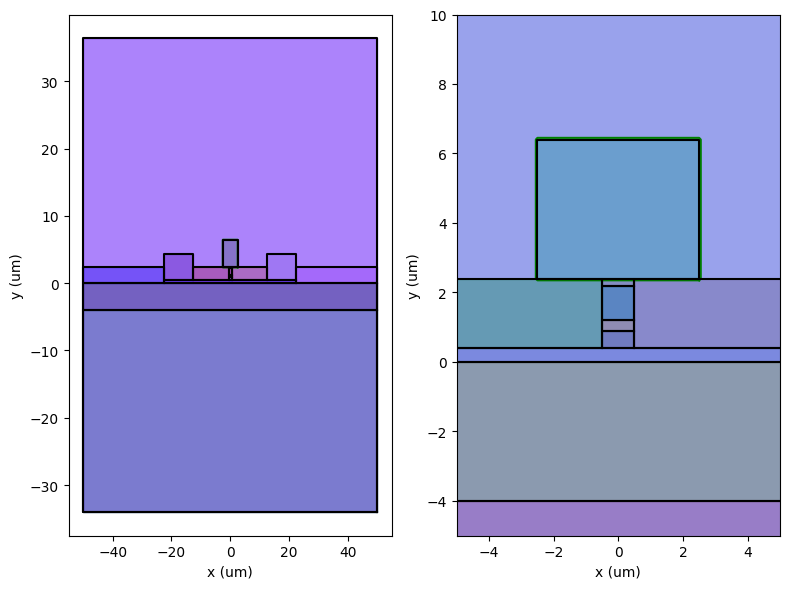

In [2]:
eopm = InP_EOPM()
eopm._make_meshes()
eopm._create_polygons()
eopm._initialize_device()

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for ax in [ax1, ax2]:
    eopm.device.plot_polygons(
        color_polygon="black",
        color_line="green",
        color_junctions="blue",
        fill_polygons=True,
        fig=fig,
        ax=ax,
    )

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,10)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax2.set_xlabel('x (um)')
ax2.set_ylabel('y (um)')

plt.tight_layout()
plt.show()

The `ChargeSimulatorSolcore` is a 1D solver, and for that, we must make sure that we select a line for our simulation. For the moment, this solver is restricted to vertical lines, and subsequent horizontal broadcasting of the results into our 2D device. The thought process in this decision stems from the fact that most of the InP-based modulators are a vertical structure and very often a single 1D solution is enough to capture carrier dynamics and the electro-optic effects, which will allows us to speed the iterative process of designing and optimizing a modulator. 

We must now select a line. This selection must be done carefully, because you are not only selecting a line, but rather a vector. That is, the first point of your line will be the zero of the origin of the simulation domain. Inverting the line can cause to invert the direction of the internal electrical field. Our advice is to place the arrow colinear with the y axis always.

You must also give it a voltage range. The voltage that is specified is the one that is applied on the first point of the line. For example, in our case, we want to reverse bias the junction. Therefore, we must apply a positive voltage to the N side. Since the N side is on the first point of the line, we need to supply a voltage array from 0 to 6 V for example.

A very important aspect is a current bug in `Solcore` that we must correct for manually. The solver internally enforces that it solves from 0V to some voltage, and the voltage you supply must be strictly increasing. In case you supply a voltage array form 0 to V then no correction is needed. But if you have an inverted junction and you supply a voltage array from -V to 0, then the solver inverts the voltage array and forgets to revert it back. Therefore, you must manually invert the voltages by doing `charge.V = charge.V[::-1]`.

Charge transport will take place with:
p2
p1
wg2
wg1
n


(-1.0, 3.0)

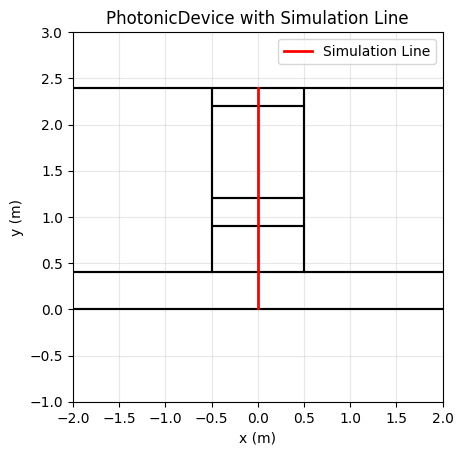

In [3]:
a=shapely.LineString([
	[0,0+0.01],
    [0,eopm.h_n+eopm.h_wg1+eopm.h_wg2+eopm.h_p1+eopm.h_p2 - 0.01]]) #simulation line

charge=ChargeSimulatorSolcore(
	device=eopm.device,
	simulation_line=a,
	bias_start_stop_step=[0,6,21]
)

fig, ax = charge.plot_with_simulation_line()

ax.set_xlim(-2,2)
ax.set_ylim(-1,3)

You can now inspect the mesh. This can be a confusing part. The x axis represents the coordinate on your actual device. However, `Solcore` enforces that the simulation space must start at 0, and it should be specified in meters. Therefore, the right axis is the simulation space. This can be a useful representation if you'd like to inspect the different mesh resolutions, as different sloped represent varying spacings.

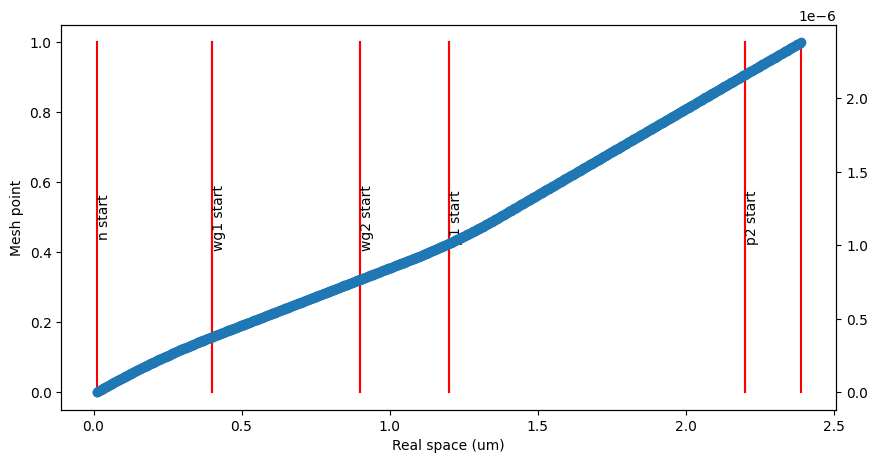

In [4]:
charge.plot_mesh()
plt.show()

Now we can solve the equations

In [5]:
charge.solve_PDD(
	verbose = True*0,
	tol = 1e-6,
	max_iter = 1000,
	smooth_output=False,
)

Material "n" does not have k-data defined. Returning "zeros"
Material "wg1" does not have k-data defined. Returning "zeros"
Material "wg2" does not have k-data defined. Returning "zeros"
Material "p1" does not have k-data defined. Returning "zeros"
Material "p2" does not have k-data defined. Returning "zeros"
Solving IV of the junctions...


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\sesame_drift_diffusion\solve_pdd.py:193: UserWarning: All voltages are positive, but junction has been identified as n-p, so the  open-circuit voltage (Voc) of the junction will be negative.
  warnings.warn(


Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


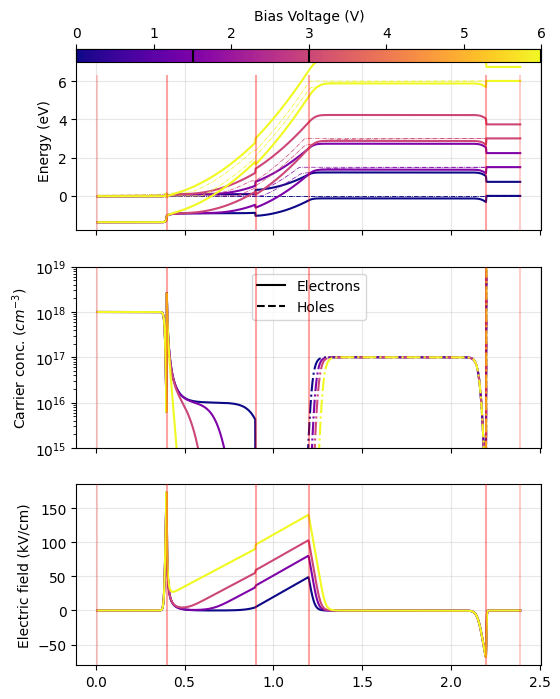

In [6]:
charge.plot_results(
	V_idx = [0, 5, 10, 20],
	cmap = 'plasma'
	)

Finally we can send this data to the device where the information is stored as a list of 2D interpolators. Note now that we must create new data to a 2D mesh, therefore, it is required that you input a xmin and xmax. These define the new mesh in the x domain in which the interpolators will be valid. Any point evaluated outside the domain will simply be extrapolated. It is also worth noting that the values of the quantities to be passed to the `PhotonicDevice` will be masked by the polygons that were involved in the charge transport simulation.

In [7]:
charge.transfer_results_to_device(xmin=-2, xmax=2, dx = 0.05)

dict_keys(['Ec', 'Ev', 'Efn', 'Efp', 'N', 'P', 'Efield', 'mun', 'mup', 'V'])


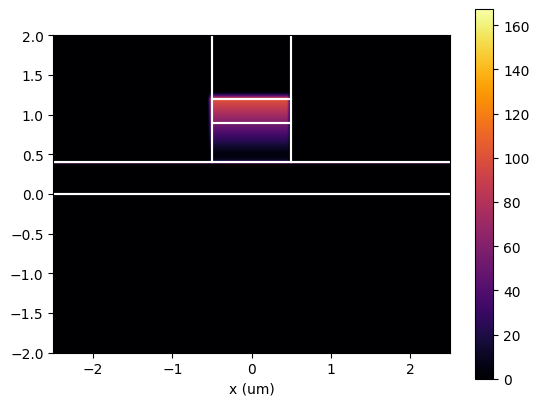

In [8]:
print(eopm.device.charge.keys())
idx_voltage = 10

x = np.linspace(-2.5,2.5,1000)
y = np.linspace(-2,2,1000)

xx,yy = np.meshgrid(x,y)

e_field_y = eopm.device.charge['Efield'][idx_voltage](xx,yy)[:,:,1].magnitude

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(e_field_y,
          extent=[x.min(), x.max(), y.min(), y.max()],
          cmap='inferno',
            origin='lower'
)

eopm.device.plot_polygons(
	color_polygon = 'white',
	fig = fig,
    ax = ax,
)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('x (um)')

fig.colorbar(im)

dict_keys(['Ec', 'Ev', 'Efn', 'Efp', 'N', 'P', 'Efield', 'mun', 'mup', 'V'])


C:\Users\20230622\AppData\Local\Temp\ipykernel_13792\1791172669.py:14: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(N),


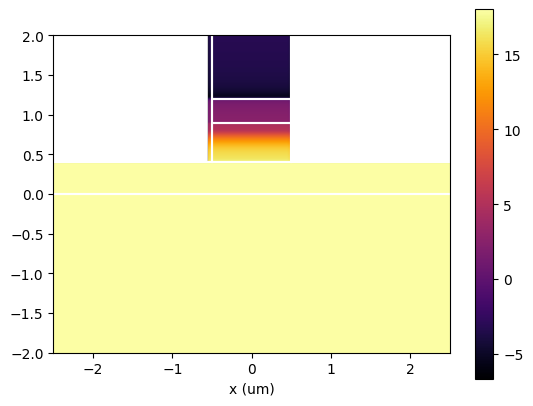

In [9]:
print(eopm.device.charge.keys())
idx_voltage = 10

x = np.linspace(-2.5,2.5,1000)
y = np.linspace(-2,2,1000)

xx,yy = np.meshgrid(x,y)

N = eopm.device.charge['N'][idx_voltage](xx,yy)[:,:].magnitude

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(np.log10(N),
          extent=[x.min(), x.max(), y.min(), y.max()],
          cmap='inferno',
            origin='lower'
)

eopm.device.plot_polygons(
	color_polygon = 'white',
	fig = fig,
    ax = ax,
)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('x (um)')

fig.colorbar(im)

Here we see a small offset relative to the polygon boundaries. This stems from the fact that we chose a sampling of the x domain of 50nm. 

Notice how above the interpolator extrapolated the charge carrier density to the bottom oxide. This is, of course, not physical. However, when we later use the charge transport data for RF calculations, we will look also for the polygons that have the flag `has_charge_transport_data` and are `SemiconductorPolygon`, thus ensuring that only the polygons that were involved in the charge transport calculations are used. We can verify that:

In [12]:
for photopolygon in eopm.device.photo_polygons:
	if hasattr(photopolygon, 'has_charge_transport_data'):
	    print(photopolygon.name, photopolygon.has_charge_transport_data)

p2 True
p1 True
wg2 True
wg1 True
n True
substrate False


The same applies to the electro optical calculations because we will look for polygons that have a valid `ElectroOpticalModel` and `has_charge_transport_data` attribute.